*Colormap of the notebook:*

* <span style="color:red">assignment problem</span>. The red color indicates the task that should be done
* <span style="color:green">debugging</span>. The green tells you what is expected outcome. Its primarily goal to help you get the correct answer
* <span style="color:blue">hints</span>.

Assignment 2b ( DTD dataset )
======================


During this assignment we will consider DTD dataset and prepare it for further use.

**Describable Textures Dataset (DTD)**  
*source*: https://www.robots.ox.ac.uk/~vgg/data/dtd/  
*description*: DTD is a texture database, consisting of 5640 images, organized according to a list of 47 terms (categories) inspired from human perception. There are 120 images for each category. Image sizes range between 300x300 and 640x640.  
*State-of-the-art accuracy*: $73.6\%$ [https://arxiv.org/abs/1511.05197]

<span style="color:red"> do in the terminal: </span>  

<span style="color:red"> 1. go the folder 'data' where assigments are </span>  

<pre> > cd $ASSIGNMENT_DIR$/data </pre>  

<span style="color:red"> 2. get the data and perform train/test partition [YOU NEED ~ 700 MB FREE] </span>  
<pre> > chmod +x get_dtd_dataset.sh </pre>  
<pre> > ./get_dtd_dataset.sh </pre>


In [2]:
# the associated webpage
import IPython
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/'
iframe = '<iframe src=' + url + ' width="100%" height=500></iframe>'
IPython.display.HTML(iframe)

##### Preliminaries

In [3]:
# compatability issues (python 2 & python 3)
from __future__ import print_function
from __future__ import division

In [4]:
# needed libs
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
# torch stuff
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
# to make interactive plotting possible
%matplotlib inline
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

### Dataset

In [7]:
# path to the data
path_data = 'data/dtd'

... Let's look at the data ...

<img src="fig/take-a-look.jpg" style="height:256px;" />

### Classes

In [8]:
classes = os.listdir(os.path.join(path_data, 'train'))

In [9]:
n_classes = len(classes)

In [10]:
print("There are " + str(len(classes)) + " classes:")
print(classes)

There are 47 classes:
['veined', 'marbled', 'fibrous', 'dotted', 'crosshatched', 'honeycombed', 'grooved', 'bumpy', 'knitted', 'freckled', 'grid', 'blotchy', 'porous', 'pitted', 'meshed', 'braided', 'perforated', 'gauzy', 'scaly', 'lined', 'spiralled', 'banded', 'woven', 'chequered', 'wrinkled', 'polka-dotted', 'smeared', 'stained', 'lacelike', 'matted', 'bubbly', 'striped', 'cracked', 'cobwebbed', 'frilly', 'paisley', 'crystalline', 'potholed', 'flecked', 'sprinkled', 'pleated', 'zigzagged', 'interlaced', 'studded', 'swirly', 'waffled', 'stratified']


### Shape, size, ...

* Number of images for each class

In [11]:
for cls in classes[:5]:
    for train_test in ['train', 'test']:
        path_dir_cls = os.path.join(path_data, train_test, cls)
        imgs_list = os.listdir(path_dir_cls)
        print( "[%s] %s : %d" % (train_test, cls, len(imgs_list)))
    print()

[train] veined : 80
[test] veined : 40

[train] marbled : 80
[test] marbled : 40

[train] fibrous : 80
[test] fibrous : 40

[train] dotted : 80
[test] dotted : 40

[train] crosshatched : 80
[test] crosshatched : 40



All classes have the same amount of images 120, 80 images in train and 40 images in test.
  
So we have $ (80 + 40) * 47 = 5640$ images

* Images sizes

The distribution of the widths/heigths are below.

<img src="fig/dtd_width.png" style="height:256px;" />

The main message is that the image sizes are different and we have to deal with it when we will train NN on them.

### Random image

In [35]:
indx_cls = np.random.randint(len(classes))
cls = classes[indx_cls]

class_images = os.listdir(os.path.join(path_data, 'train', cls))
indx_im = np.random.randint(len(class_images))

im_name = class_images[indx_im]
im_full_name = os.path.join(path_data, 'train', cls, im_name)

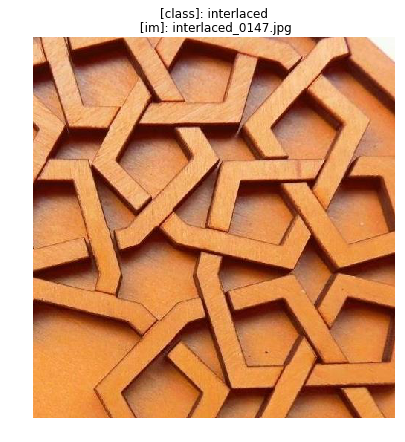

In [36]:
im = Image.open(im_full_name)
plt.figure(figsize=(7, 7))
plt.imshow(im)
plt.title("[class]: " + cls + "\n [im]: " + im_name);
plt.axis('off');

### Look more closely 

<span style="color:red"> You are invited to play with code below  </span>  

<span style="color:red"> - change 'samples_per_class' </span>  
<span style="color:red"> - look at different classes by changing 'classes_to_see' </span>  
<span style="color:red"> - try 'train' vs 'test' by changing 'train_test' variable </span>  

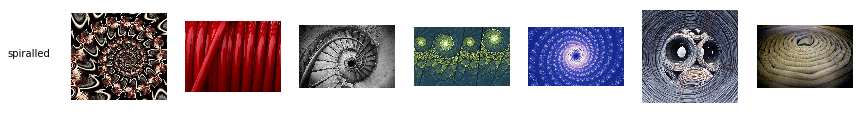

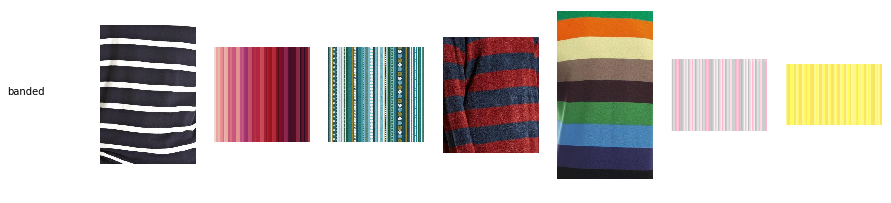

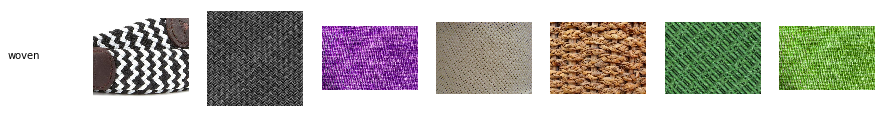

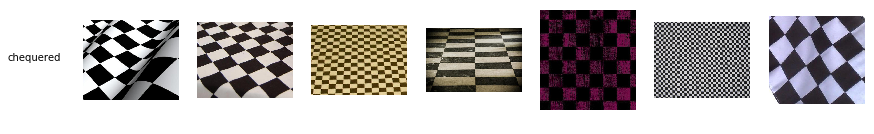

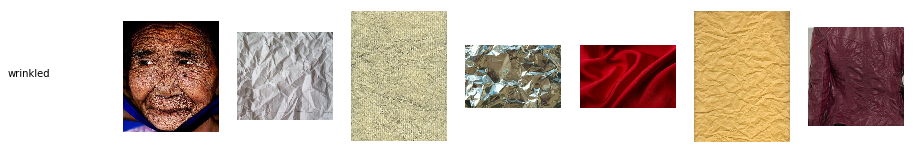

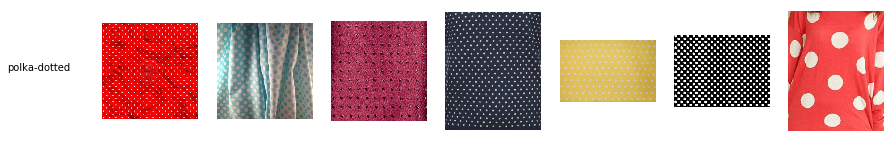

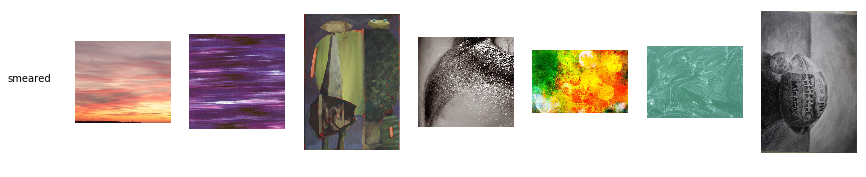

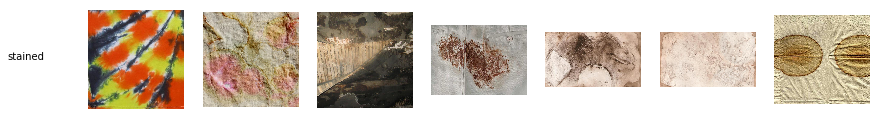

In [41]:
samples_per_class = 7
classes_to_see = np.arange(20,28)
#classes_to_see = [1,2,3]
train_test = "train"
#train_test = "test"
for cls in [classes[i] for i in classes_to_see]:
    class_images = os.listdir(os.path.join(path_data, train_test, cls))
    class_images_pick = np.random.choice(class_images, samples_per_class, replace=False)
    
    plt.figure(figsize=(2 * samples_per_class, 5))    
    for i, im_name in enumerate(class_images_pick):
        plt_idx = i + 1
        plt.subplot(1, samples_per_class, plt_idx)
        im_full_name = os.path.join(path_data, train_test, cls, im_name)
        im = Image.open(im_full_name)
        plt.imshow(im)
        plt.axis('off')
        if i == 0:
            im_x, im_y = im.size
            plt.text(-400, im_y / 2, cls)

### Transformations

It is common in Computer Vision to make different image transforms.  
*pytorch* (*torchvision* to be more precise) provides several commony used transforms and tools to combine these transforms.

Plese visit for details
https://github.com/pytorch/vision#transforms

Let check different transformation

First we define useful functions:

In [42]:
def tensor2im(tensor_):
    """ Bring the tensor back to image"""
    return transforms.ToPILImage()(tensor_)

def display_diff(im, im_transformed):
    """ Display a difference between original image and transformed"""
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(im_transformed)
    plt.title('transformed')    

* load an image

In [43]:
im_dir = os.path.join(path_data, 'train', classes[8])
im_full_name = im_dir + "/" + os.listdir(im_dir)[3]
im = Image.open(im_full_name)

* define transform itself

In [44]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
])

In words we define the following transformation:  
1. crop the image at the center to have a region of the given size (224 in our case)
2. randomly horizontally flips the given image with a probability of 0.5

* apply transform and check the difference

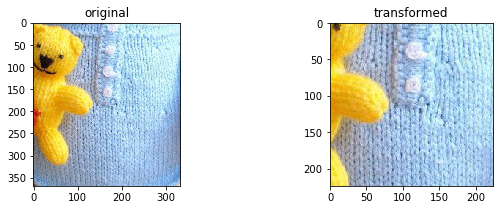

In [45]:
# apply transform
im_transformed = transform(im)
# display results
display_diff(im, im_transformed)

<span style="color:red"> **[PROBLEM I]**: </span> 

<span style="color:red">Define the following transform </span>  
<span style="color:red">1. crop the image at a random location to have a region of the given size (230)</span>  
<span style="color:blue">use 'RandomCrop'    https://github.com/pytorch/vision#randomcropsize-padding0</span>    
<span style="color:red">2. randomly horizontally flip the given image </span>  
<span style="color:red">3. Rescale the input image to the given 'size' (32) </span>  
<span style="color:blue"> consider to use 'Scale' https://github.com/pytorch/vision#scalesize-interpolationimagebilinear </span>  

<span style="color:red"> apply this transform and see the results </span> 

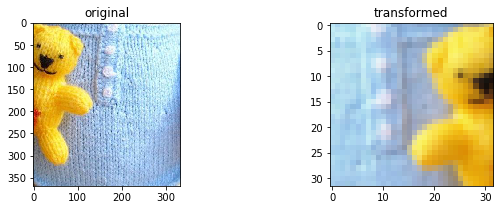

In [47]:
#YOUR CODE HERE
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Scale(32)
])
# apply transform
im_transformed = transform(im)
# display results
display_diff(im, im_transformed)

Another interesting tranformation is normalization, commonly used to normalize an image, prior to training  
It operates on a Tensor, rather than an image and requires two params - mean & std

In [48]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

Let's look how it works

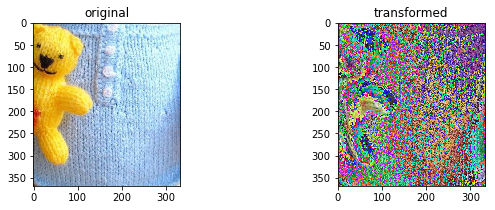

In [49]:
# apply transform
tensor_transformed = transform(im)
# convert tensor to image
im_transformed = tensor2im(tensor_transformed)
# display results
display_diff(im, im_transformed)

<span style="color:red"> **[PROBLEM II]**: </span> 

<span style="color:red">Implement the function, which makes inverse transformation</span>

<span style="color:blue">look at realization of 'normalize' transform in</span>   https://github.com/pytorch/vision/blob/master/torchvision/transforms.py#L129  
<span style="color:blue"> consider to use in-place version of tensor operations as in the example of 'normalize' transform above </span>   

In [70]:
def unnormalize(tensor, mean, std):    
    """
    Make inverse transform to 'normalize'
    
    Args:
        tensor (torch.Tensor): Tensor to unnormalize
        mean (sequence)      : Sequence of means for R, G, B channels respectively.
        std (sequence)       : Sequence of standard deviations for R, G, B channels respectively.  
        
    Returns:
        torch.Tensor: unnormalized tensor.
    """
    #YOUR CODE HERE
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor 

<span style="color:green">when running the following cell you have to see identical images</span> 

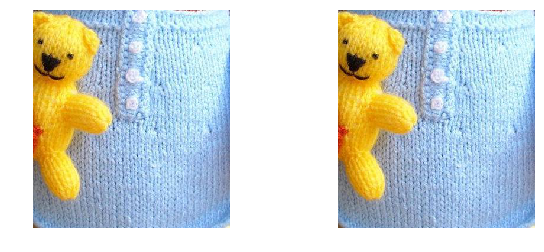

In [69]:
im_back = tensor2im(unnormalize(transform(im), imagenet_mean, imagenet_std))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(im_back)
plt.axis('off');

### Datasets and data loaders

To work with datasets pytorch provides useful abstractions, like *dataset* and *dataloder* [https://github.com/pytorch/vision#datasets].  
There are 
* prepared datasets, like MNIST, CIFAR10 and CIFAR100, COCO, etc.
* *ImageFolder* dataset, which allows you to cook dataset for yourself without much efforts.


The later is used here for DTD dataset and is especially useful when working with new data.

On top of the *dataset* there is *dataloader*.
The *dataloader* is used, as name suggests, to load the data.  
It does that efficiently, with multi-threading, so you should not worry about how to feed you model with the data.

Have a look at src/data_set.py where the *DataSetDTD* is defined.  
There train & test dataloaders are bundled together, for convinence.

In [73]:
from src.data_set import DataSetDTD

In [76]:
data_set = DataSetDTD(path_data, num_dunkeys=4, batch_size=100, fin_scale=32)

To iterate over train set

In [77]:
# When iteration starts, queue and thread start to load dataset from files.
data_iter = iter(data_set.loader['train'])

# Mini-batch images and labels.
images, labels = data_iter.next()

print (images.size())
print (labels.size())

torch.Size([100, 3, 32, 32])
torch.Size([100])


To iterate over test set

In [78]:
# When iteration starts, queue and thread start to load dataset from files.
data_iter = iter(data_set.loader['test'])

# Mini-batch images and labels.
images, labels = data_iter.next()

print (images.size())
print (labels.size())

torch.Size([100, 3, 32, 32])
torch.Size([100])
